<a href="https://colab.research.google.com/github/ind-genomics/FUN-TB/blob/main/FuNTB_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FunTB collaborators

| **Authors**                          |                              |
| ------------------------------------ | ---------------------------- |
| Paulina Mayell Mejía Ponce, PhD      | a00829610@tec.mx             |
| Axel Alejandro Ramos-García, PhD candidate | alejandro.ramosg14@tec.mx  |
| Nelly Sélem Mojica, PhD              | nselem@matmor.unam.mx        |
| Juan Emmanuel Matínez Ledesma, PhD   | juanemmanuel@tec.mx          |
| Yazmín Águeda Rios Solis, PhD         | yasmin.riossolis@tec.mx      |
| Alejandro Santos Díaz, PhD            | alejandro.santos@tec.mx      |
| Cuauhtémoc Licona Cassani, PhD        | clicona@tec.mx               |


## Set up libraries

In [ ]:
import ast
import csv
import itertools
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pandas as pd
import plotly.express as px
import random
import requests
import seaborn as sns
import sys
import statistics

from collections import Counter
from deap import base, creator, tools
from itertools import permutations
from matplotlib.pyplot import figure
from matplotlib.legend import Legend
from networkx.classes.function import edges
from random import sample
from scipy import stats

# FunTB

### Functions Definitions

#### Network Data Generation

This set of functions aims to extract and summarize information from each sample group, including gene data, mutated positions, and alteration frequencies. These functions facilitate comparisons between every group and each analyzed gene, identifying positions that are unique to each group.

##### Functions

> **GenerateGroupsPermutations**: Generates all possible permutations of pairs within a given list of groups.

> **GenesData**: Retrieves position and frequency data from samples_variations for the given samples.

> **UpdatePositions**: This function's purpose is to return every gene variation information once two sets have been compared.

> **RelevantPositions**: Filters out positions from experimentalPositions that are not present in controlPositions.


> **UncommonPositions**: Returns a dictionary containing the positions of genes in the experimental group that are uncommon or absent in the control group. If a gene is present in both groups, the positions of that gene are compared and stored.

> **RelevantGenes**: Filters out genes from uncommon_genes that have no variations.

> **RemovePPandPE**: Removes genes that start with "ppe", "pp_", "pe_", "PPE", "PP_", or "PE_" from a list.

In [ ]:
def update_positions(A,B):
  '''
  The purpose of this function is to return a dictionary that contains every gene variation information gene:{position: frequency}, calculated along with every individual within the sample

  Args:
    'A' (list): Current dicitonary of position's variations
    'B' (list): New dictionary of positions to update A

  Returns:
    dict: Comprised by position's variations and its frequency, updating A list keys and values using B list.
  '''
  return {x: A.get(x, 0) + B.get(x, 0) for x in set(A).union(B)}

def generate_groups_permutations(groups):
  """
    Generates all possible permutations of pairs within a given list of groups.

    Parameters:
        groups (list): A list of groups.

    Returns:
        list: A list of tuples representing all possible permutations of pairs within the groups.

    Example:
        groups = ['A', 'B', 'C']
        permutations = generate_groups_permutations(groups)
        print(permutations)
        # Output: [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
  """
  return list(permutations([i for i in range(len(groups))], 2))

def GenesData(samples, samples_variations):
  """
    Retrieves gene data from samples_variations for the given samples.

    Parameters:
        samples (list): A list of sample names.
        samples_variations (dict): A dictionary containing sample variations data.

    Returns:
        dict: A dictionary containing gene data aggregated from samples_variations.

    Example:
        samples = ['Sample1', 'Sample2', 'Sample3']
        variations = {
            'Sample1': {
                'GeneA': {'variation positions': [1, 2, 3]},
                'GeneB': {'variation positions': [4, 5]},
            },
            'Sample2': {
                'GeneA': {'variation positions': [2, 3]},
                'GeneC': {'variation positions': [6]},
            },
            'Sample3': {
                'GeneB': {'variation positions': [4, 5]},
                'GeneD': {'variation positions': [7, 8]},
            },
        }
        gene_data = GenesData(samples, variations)
        print(gene_data)
        # Output: {'GeneA': [1, 2, 3], 'GeneB': [4, 5], 'GeneC': [6], 'GeneD': [7, 8]}

  """
  genes_data = {}
  for sample in samples:
    genes = list(samples_variations[sample].keys())
    for gene in genes:
      if gene.startswith("ppe") or gene.startswith("pp_") or gene.startswith("pe_") or gene.startswith("PPE") or gene.startswith("PP_") or gene.startswith("PE_"):
        pass
      else:
        if gene not in genes_data:
          genes_data[gene] = samples_variations[sample][gene]['variation_positions']
        else:
          genes_data[gene] = update_positions(genes_data[gene],samples_variations[sample][gene]['variation_positions'])
  return genes_data

def relevant_positions(experimentalPositions,controlPositions):
  """
    Filters out positions from experimentalPositions that are not present in controlPositions.

    Parameters:
        experimentalPositions (dict): A dictionary of experimental positions.
        controlPositions (set): A set of control positions.

    Returns:
        dict: A dictionary containing relevant positions from experimentalPositions.

    Example:
        experimental = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
        control = {'B', 'D'}
        relevant = relevant_positions(experimental, control)
        print(relevant)
        # Output: {'A': 1, 'C': 3}

  """
  rpos = {}
  for position in experimentalPositions.keys():
    if position not in controlPositions:
      rpos[position] = experimentalPositions[position]
  return rpos

def uncommon_positions(experimental_group,control_group):
  """
    Returns a dictionary containing the positions of genes in the experimental group that are uncommon or absent
    in the control group. If a gene is present in both groups, the positions of that gene are compared and stored.

    Args:
        experimental_group (dict): Dictionary representing the experimental group.
            Keys represent genes, and values contain relevant information including positions.
        control_group (dict): Dictionary representing the control group.
            Keys represent genes, and values contain relevant information including positions.

    Returns:
        dict: A dictionary containing the positions of genes in the experimental group that are uncommon or absent
        in the control group. If a gene is present in both groups, the positions of that gene are compared and stored.
        The keys of the dictionary are genes, and the values are either the positions or the result of the comparison.
  """
  gene_pos = {}
  genes_of_interes = experimental_group.keys()
  for gene in genes_of_interes:
    if gene in control_group.keys():
      gene_pos[gene] = relevant_positions(experimental_group[gene],control_group[gene])
    else:
      gene_pos[gene] = experimental_group[gene]
  return gene_pos

def relevant_genes(uncommon_genes):
  """
    Filters out genes from uncommon_genes that have no variations.

    Parameters:
        uncommon_genes (dict): A dictionary of uncommon genes.

    Returns:
        dict: A dictionary containing relevant genes from uncommon_genes along with additional information.

    Example:
        uncommon = {'GeneA': {'Pos1': 2, 'Pos2': 1}, 'GeneB': {}, 'GeneC': {'Pos3': 4}}
        relevant = relevant_genes(uncommon)
        print(relevant)
        # Output: {'GeneA': [2, {'Pos1': 2, 'Pos2': 1}, 3], 'GeneC': [1, {'Pos3': 4}, 4]}

  """
  relevant_genes = {}
  for gene in uncommon_genes.keys():
    if len(uncommon_genes[gene]) > 0:
      relevant_genes[gene] = uncommon_genes[gene]
  return relevant_genes

def remove_pp_and_pe(gene_nodes):
  """
  Removes gene nodes that start with "ppe", "pp_", "pe_", "PPE", "PP_", or "PE_" from a list.

  Parameters:
    gene_nodes (list): A list of gene nodes.

  Returns:
    list: A list containing the gene nodes that do not start with the specified prefixes.

  Example:
    >>> gene_list = ['ppeGene', 'pp_Gene', 'pe_Gene', 'PPEGene', 'PP_Gene', 'PE_Gene', 'OtherGene']
    >>> remove_pp_and_pe(gene_list)
    ['OtherGene']
  """
  nodes2remove = []
  for gene in gene_nodes:
    if gene.startswith("ppe") or gene.startswith("pp_") or gene.startswith("pe_") or gene.startswith("PPE") or gene.startswith("PP_") or gene.startswith("PE_"):
      nodes2remove.append(gene)
  return nodes2remove

#### Network Structure Generation

This set of functions is designed to extract and summarize information from each sample group, including gene data, mutated positions, and alteration frequencies. The functions facilitate a comparison between every group and each analyzed gene, identifying positions that are unique to each group.

##### Functions

> **GetNetwork:** Structures the phenotypic-centered network, generating the edges to establish the connection between ego nodes (phenotype) and alter nodes (genes) that present at least one variation.

> **GetGroupsGenesInformation**: Summarizes the gene information for each group, updating the information about the variation present in each gene as well as the frequency of every alteration.

> **AlterationDensityScore**: This metric measures the distribution density of the variations present within each gene. It is the resulting outcome of the ratio between the sum of every alteration and the number of variable positions.

> **DominantAlteredGeneScore**: This second metric measures the highest value of frequency of each gene compared to the others. It is the result of the ratio between the top value of the altered frequency and the number of altered positions.

> **ClusterDiversityAlterationScore**: This metric helps us to see the behavior of the gene compared to every other gene within the same aggregation. It is the result of the ratio comparing the total variations and the total members of the associated cluster.

> **CAIS**: This final metric comprises the three previous metrics and weights the contribution of each based on some factors (α, β, γ) to calibrate the gene ranking. This score is reflected in node size.

> **get_colors**: Based on the number of existing n-groups, it generates n random colors to assign them to each cluster, making it easier to map operations when post-processing in Cytoscape.


In [ ]:
def GetNetwork(groups_names, relevant_genes_data):
  """
  Constructs a network graph using the provided group names and relevant genes data.

  Parameters:
    group_names (list): A list of group names.
    relevant_genes_data (list): A list of dictionaries containing relevant genes data for each group.

  Returns:
    networkx.Graph: A network graph constructed from the group names and relevant genes data.

  Example:
    >>> groups = ['Group A', 'Group B', 'Group C']
    >>> genes_data = [
    ...   {'Gene1': 0.5, 'Gene2': 0.8, 'Gene3': 0.3},
    ...   {'Gene2': 0.6, 'Gene3': 0.2, 'Gene4': 0.9},
    ...   {'Gene1': 0.4, 'Gene3': 0.7, 'Gene4': 0.5}
    ... ]
    >>> network = GetNetwork(groups, genes_data)
    >>> network.nodes()
    ['Group A', 'Group B', 'Group C', 'Gene1', 'Gene2', 'Gene3', 'Gene4']
    >>> network.edges()
    [('Group A', 'Gene2'), ('Group A', 'Gene3'), ('Group B', 'Gene3'), ('Group B', 'Gene4'), ('Group C', 'Gene3'), ('Group C', 'Gene4')]

  Note:
    - The function uses the 'networkx' library to construct the network graph.
    - The 'relevant_genes_data' list contains dictionaries where the keys are gene names and the values are relevant data associated with each gene.
    - The function connects the group names with genes that are common across multiple groups based on the 'relevant_genes_data'.
    - The function removes nodes without edges and nodes starting with "ppe", "pp_", "pe_", "PPE", "PP_", or "PE_" using the 'remove_pp_and_pe' function.

  """
  Variation_Graph = nx.Graph()
  Variation_Graph.add_nodes_from(groups_names)

  gropus_genes = []

  for i in range(len(groups_names)):
    lower_bound = (len(groups_names)-1)*(i)
    upper_bound = (i+1)*(len(groups_names)-1)
    genes = set(relevant_genes_data[lower_bound].keys())
    for j in range(lower_bound + 1, upper_bound): # upper_bound-1
      genes = set(genes.intersection(relevant_genes_data[j].keys()))
    gropus_genes.append(genes)

    edges = [(groups_names[i], gene) for gene in genes]
    Variation_Graph.add_edges_from(edges)
    Variation_Graph.add_nodes_from(genes)

  # Find nodes without edges
  nodes_without_edges = [node for node in Variation_Graph.nodes() if Variation_Graph.degree[node] == 0]

  # Remove nodes without edges
  Variation_Graph.remove_nodes_from(nodes_without_edges)

  # Find nodes without edges
  pp_ppe_nodes = remove_pp_and_pe(Variation_Graph.nodes())

  # Remove nodes without edges
  Variation_Graph.remove_nodes_from(pp_ppe_nodes)

  return Variation_Graph, gropus_genes

def GetGroupsGenesInformation(groups_names, Groups_genes_network, relevant_genes_data):
  """
    Retrieve information about genes in different groups.

    Args:
        groups_names (list): A list of group names.
        Groups_genes_network (list): A list of lists representing the gene network for each group.
        relevant_genes_data (list): A list of dictionaries containing relevant gene information.

    Returns:
        dict: A dictionary mapping group names to gene information.

  """
  group_genes_information = {}
  for i, group_name in enumerate(groups_names):
    group_genes_information[group_name] = {}
    for gene in Groups_genes_network[i]:
      lower_bound = (len(groups_names)-1)*(i) # Start-reading position
      upper_bound = (i+1)*(len(groups_names)-1) # End-reading position
      group_genes_information[group_name][gene] = {}
      for j in range(lower_bound, upper_bound):
        group_genes_information[group_name][gene] = update_positions(group_genes_information[group_name][gene], relevant_genes_data[j][gene])
  return group_genes_information

def FitnessScore(Group_genes_information, Variations_network):
    """
    Calculates the fitness score based on the group gene information and updates the variation network.

    Parameters:
        Group_genes_information (dict): A dictionary containing information about group genes.
        Variations_network (networkx.Graph): The variation network to be updated.

    Returns:
        None
    """

    # Initialize an empty dictionary to store fitness score for each gene
    Fitness_score_genes_info = {}

    # Calculate fitness score for each gene in each group
    for group, genes in Group_genes_information.items():
        for gene in genes:
            if gene not in Fitness_score_genes_info:
                Fitness_score_genes_info[gene] = Group_genes_information[group][gene]
            else:
                Fitness_score_genes_info[gene] = update_positions(Fitness_score_genes_info[gene], Group_genes_information[group][gene])

    # Update the variation network with the calculated fitness scores
    for gene, variations in Fitness_score_genes_info.items():
        Variations_network.nodes[gene]['size'] = sum(variations.values()) / len(variations)

def GetPSVComponents(nodes, groups_names):
  """
    Calculates the z-scores of node sizes for nodes that are not in groups_names.

    Parameters:
        nodes (networkx.Graph): The graph object containing the nodes.

    Returns:
        fs (list): A list of node sizes for nodes not in groups_names.
        z_scores (numpy.ndarray): An array of z-scores calculated from fs.
  """
  fs = []
  zsc = []
  new_nodes = []

  for node in nodes:
    if node not in groups_names:
      new_nodes.append(node)
      fs.append(nodes[node]['size'])
    else:
       pass
  z_scores = stats.zscore(fs)
  return fs, z_scores, new_nodes

def normalize(values_to_normalize, method):
  """
    Normalizes a given array of values using different normalization methods.

    Parameters:
        values_to_normalize (list or numpy.ndarray): The array of values to be normalized.
        method (str): The normalization method to be used. Supported options are 'min_max', 'zsc', 'log', and any other value for 'robust' scaling.

    Returns:
        numpy.ndarray: The normalized values based on the specified method.

    Raises:
        None

    Example:
        values = [1, 2, 3, 4, 5]
        normalized_values = normalize(values, 'min_max')
        print(normalized_values)
        # Output: [0.0, 0.25, 0.5, 0.75, 1.0]

  """
  values_to_normalize = np.array(values_to_normalize)
  # Min-Max Scaling
  if method == 'min_max':
    normalized_ps_values = (values_to_normalize - np.min(values_to_normalize)) / (np.max(values_to_normalize) - np.min(values_to_normalize))
  # Z-score Standardization
  elif method == 'zsc':
    normalized_ps_values = (values_to_normalize - np.mean(values_to_normalize)) / np.std(values_to_normalize)
  # Log Transformation
  elif method == 'log':
    normalized_ps_values = np.log(values_to_normalize + 1)
  # Robust Scaling
  else:
    normalized_ps_values = (values_to_normalize - np.median(values_to_normalize)) / (np.percentile(values_to_normalize, 75) - np.percentile(values_to_normalize, 25))

  return normalized_ps_values

def CalculatePSVScore(Varitations_network_nodes, fitess_Scores, z_scores, alpha_factor, groups_names, nodes):
  """
    Calculates the PSV (Protein-Specific Variation) score for each gene in the variation network.

    Parameters:
        Variations_network_nodes (list): A list of nodes in the variation network.
        fitness_Scores (list): A list of fitness scores for the genes.
        z_scores (list): A list of z-scores for the genes.
        alpha_factor (float): A weight factor for combining fitness scores and z-scores.
        groups_names (list): A list of group names to exclude from calculation.

    Returns:
        None
  """
  #nodes  = [node for node in list(Varitations_network_nodes) if node not in groups_names]
  pvs_scores = [(alpha_factor*fitess_Scores[i]) + ((1-alpha_factor)*z_scores[i]) for i in range(len(fitess_Scores))]
  pvs_scores = normalize(pvs_scores, 'log')
  z_scores = normalize(z_scores, 'log')

  Pareto_Front_nodes = {}

  for i, gene_node in enumerate(nodes):
    Varitations_network_nodes[gene_node]['size'] = pvs_scores[i]
    Pareto_Front_nodes[gene_node] = {}
    Pareto_Front_nodes[gene_node]['pvs'] = pvs_scores[i]
    Pareto_Front_nodes[gene_node]['sigma'] = z_scores[i]

  return Pareto_Front_nodes

# Alteration density score
def AlterationDensityScore(number_of_variations, number_of_positions):
   return round(number_of_variations/number_of_positions, 4)

# Dominant Altered gene score
def DominantAlteredGeneScore(max_gene_variations, number_of_variations):
   return round(max_gene_variations/number_of_variations, 4)

# Cluter Diversity Alteration Score
def ClusterDiversityAlterationScore(number_of_variations, total_groups_genes):
   return round(number_of_variations/total_groups_genes, 4)

# Comprehensive Alteration Impact Score (CAIS)
def CAIS(alteration_density_score, dominant_altered_gene_score, custer_diversity_score, alpha, beta, gamma):
  #assert alpha + beta + gamma == 1,"Coefficients addition is different to one"
  cais = alpha*(alteration_density_score) + beta*(dominant_altered_gene_score) + gamma*(custer_diversity_score)
  return round(cais, 4)


def GetTotalGroupGenes(gene, Variations_network):
   # Gtting the gene neighbours
   neighbours = set(list(Variations_network.neighbors(gene)))

   # Counting total genes neighbours
   gene_neighbours = set()

   for neighbour in neighbours:
      new_neighbours = set(list(Variations_network.neighbors(neighbour)))
      gene_neighbours = gene_neighbours.union(new_neighbours)

   return len(gene_neighbours)

# Get CAIS per gene
def GetCAIS(Group_genes_information, Variations_network, alpha, beta, gamma):
    # Initialize an empty dictionary to store fitness score for each gene
    genes_updated_info = {}

    # Genes positions update for score calculation
    for group, genes in Group_genes_information.items():
        for gene in genes:
            if gene not in genes_updated_info:
                genes_updated_info[gene] = Group_genes_information[group][gene]
            else:
                genes_updated_info[gene] = update_positions(genes_updated_info[gene], Group_genes_information[group][gene])

    # Scores calculation
    genes_scores = {}
    for gene, variations in genes_updated_info.items():
       genes_scores[gene] = {}
       # Alteration Density Score
       genes_scores[gene]['ads'] = AlterationDensityScore(sum(variations.values()), len(variations)) # number_of_variations, number_of_positions

       # Dominant Altered gene score
       genes_scores[gene]['dags'] = DominantAlteredGeneScore(max(variations.values()), sum(variations.values())) # max_gene_variations, number_of_variations

       # Cluter Diversity Alteration Score
       total_groups_genes = GetTotalGroupGenes(gene, Variations_network)
       genes_scores[gene]['cdas'] = ClusterDiversityAlterationScore(sum(variations.values()), total_groups_genes) # number_of_variations, total_groups_genes

       # Comprehensive Alteration Impact Score (CAIS)
       genes_scores[gene]['cais'] = CAIS(genes_scores[gene]['ads'], genes_scores[gene]['dags'], genes_scores[gene]['cdas'], alpha, beta, gamma)

    # Scores normalization
    for gene, scores in genes_scores.items():
       pass

    # Update the variation network with the calculated fitness scores
    '''
    for gene, variations in genes_updated_info.items():
      Variations_network.nodes[gene]['size'] = sum(variations.values()) / len(variations)
    '''
    return genes_scores

# Groups nodes colors
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

#### Pareto Front Extraction

In [ ]:
# Define the Pareto front criteria
def dominates(point1, point2):
    return all(p1 >= p2 for p1, p2 in zip(point1, point2)) and any(p1 > p2 for p1, p2 in zip(point1, point2))

def find_pareto_front(data):
    points = data.to_numpy()
    pareto_front = []

    for i, point in enumerate(points):
        if all(not dominates(point, other_point) for other_point in points):
            pareto_front.append(i)

    return pareto_front

###

### Data Retrieval

The CRyPTIC project has furnished the world's most extensive database focused on Mycobacterium tuberculosis, with the primary objective of investigating drug resistance in strains originating from twenty-seven different countries. Its central goal is to uncover the genetic factors that underlie the development of immunity and expedite diagnostic procedures in this critical area of research.

In this analysis, we investigated 461 Mycobacterium samples, categorizing them into two groups: HIV-positive and HIV-negative. We compared the presence and frequency of SNPs in specific positions, summarizing our findings through a phenotype-centric network visualization.

In [ ]:
# Input parameters
Network_name = 'HIV_network' # Name to sav the file
#Variations_dictionary_file = sys.argv[2] # Variation dictionary File (.txt)
Parteto_frontiers = 30 # Select top genes to show up within the network representation (integer)
Lambda_factor = 0.7 # Ponderation factor for system calibration (float [0-1])
Group_Lists = sys.argv[5:] # Groups list files (.txt)
FunTB_dir = os.getcwd() # Current work directory

# Loading input files
nsvd_url = 'https://raw.githubusercontent.com/ind-genomics/FUN-TB/main/Test/HIV_Variations_Dictionary.txt'
response = requests.get(nsvd_url)
if response.status_code == 200:
    content = response.text
    non_synonym_variation_data_dictionary = ast.literal_eval(content)

# Inputs
samples_HIV = []

# Metadata file load
Metadata_df = pd.read_csv('https://raw.githubusercontent.com/ind-genomics/FUN-TB/main/Test/hiv_metadata.csv', encoding = 'utf-8')

# Ids correspondance names
correspondance_df = pd.read_csv('https://raw.githubusercontent.com/ind-genomics/FUN-TB/main/Test/accesiones.tsv', delimiter='\t', encoding = 'utf-8')

# Corresponding dictionary
correspondance_dictionary = {}
for sample_name, Run_name in zip(correspondance_df['Sample'], correspondance_df['Run']):
  correspondance_dictionary[sample_name] = Run_name + '_lib01'

# Generating samples' lists
VIH_positive_Samples = []
VIH_negative_Samples = []

for vih_status, sample in zip(Metadata_df['HIV'], Metadata_df['ENA_SAMPLE']):
  if vih_status == 'tested, positive' and correspondance_dictionary[sample] in non_synonym_variation_data_dictionary.keys():
    VIH_positive_Samples.append(correspondance_dictionary[sample])
  elif vih_status == 'tested, negative' and correspondance_dictionary[sample] in non_synonym_variation_data_dictionary.keys():
    VIH_negative_Samples.append(correspondance_dictionary[sample])

Group_Lists = ['+VIH_patients', '-VIH_patients']
groups = [VIH_positive_Samples, VIH_negative_Samples]

### Processes

#### Alteration density score (ADS)
> Measures the density of alterations within a gene by calculating the ratio of the number of variations to the total number of positions. Higher scores may indicate genes with denser alterations.

\begin{align*}
    ADS_G(P,V) &= \frac{\sum_{i=0}^{k}f_{GVP_i}}{\sum_{i=0}^{k}G_{VP_i}}, \\
\end{align*}

#### Dominant Altered gene score (DAGS)
> Evaluates the dominance of gene alterations by considering the ratio of the maximum gene variations to the total number of variations. This score highlights genes with a dominant presence of alterations.

\begin{align*}
    DAGS (v) &= \frac{max(v)}{\sum(v)},\\
\end{align*}

#### Cluter Diversity Alteration Score (CDAS)
> Assesses the diversity of alterations across phenotypical groups by calculating the ratio of the number of variations to the total number of genes across groups. Higher scores suggest genes with alterations distributed across different groups.

\begin{align*}
    CDAS (v, G) &= \frac{v}{\sum(G)},\\
\end{align*}

#### Comprehensive Alteration Impact Score (CAIS)
> Integrates multiple aspects of gene alterations using a weighted combination of the Alteration Density Score, Dominant Altered Gene Score, and Cluster Diversity Alteration Score.

\begin{align*}
    CAIS(x) &= (ADS_{G}, DAGS, CDAS, \alpha, β, γ) \\
    CAIS(x) &= (\alpha ADS_{G} + βDAGS, γ CDAS) \\
\end{align*}

These metrics provide a comprehensive way to evaluate the impact and relevance of gene alterations. You can use them to rank genes or prioritize further analysis.

In [ ]:
#@title FuNTB
Parteto_frontiers = 30

## Extracting groups names
groups_names = Group_Lists

## Get combinations of indexes for groups comparisons - Unique genes and common positions removal
groups_comparisons = generate_groups_permutations(groups)

## Extract genes' information (variations and their relative frequency)
Groups_genes_data = []
for i,group_samples in enumerate(groups):
  Groups_genes_data.append(GenesData(group_samples, non_synonym_variation_data_dictionary))

## Perform group comparisons to remove common variable positions
relevant_genes_data = []
for group_comparison in groups_comparisons:
  relevant_genes_data.append(relevant_genes(uncommon_positions(Groups_genes_data[group_comparison[0]],
                                                               Groups_genes_data[group_comparison[1]])))
# Network Struture
## Get network components (Gene nodes, Group nodes and edges)
Variations_network, Groups_genes_network = GetNetwork(groups_names, relevant_genes_data)

## Setting network attributes (Node size --> Fitness score, Node color --> Degree or Group link, Edge weigth --> pvs contribution)
Group_genes_information = GetGroupsGenesInformation(groups_names, Groups_genes_network, relevant_genes_data)

# Update genes alteration information
Score_genes_info = {}

for group, genes in Group_genes_information.items():
  for gene in genes:
    if gene not in Score_genes_info:
      Score_genes_info[gene] = Group_genes_information[group][gene]
    else:
      Score_genes_info[gene] = update_positions(Score_genes_info[gene], Group_genes_information[group][gene])

# Metrics calculation
gene_scores = {}

for gene, positions in Score_genes_info.items():
  if gene in Variations_network.nodes():
    gene_scores[gene] = {}
    Alteraton_Density_Score = AlterationDensityScore(sum(Score_genes_info[gene].values()), len(Score_genes_info[gene]))
    gene_scores[gene]['ADS'] = Alteraton_Density_Score

    Dominant_Altered_Gene_Score = DominantAlteredGeneScore(max(Score_genes_info[gene].values()), len(Score_genes_info[gene]))
    gene_scores[gene]['DAGS'] = Dominant_Altered_Gene_Score

    number_of_neighbours = GetTotalGroupGenes(gene, Variations_network)
    Cluster_Diversity_Alteration_Score = ClusterDiversityAlterationScore(len(Score_genes_info[gene]), number_of_neighbours)
    gene_scores[gene]['CDAS'] = Cluster_Diversity_Alteration_Score

# Define a function to perform Min-Max scaling normalization
def min_max_scaling(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

# Find the minimum and maximum values for each variable (ADS, DAGS, CDAS)
min_ads = min([gene_scores[gene]['ADS'] for gene in gene_scores])
max_ads = max([gene_scores[gene]['ADS'] for gene in gene_scores])

min_dags = min([gene_scores[gene]['DAGS'] for gene in gene_scores])
max_dags = max([gene_scores[gene]['DAGS'] for gene in gene_scores])

min_cdas = min([gene_scores[gene]['CDAS'] for gene in gene_scores])
max_cdas = max([gene_scores[gene]['CDAS'] for gene in gene_scores])

# Apply Min-Max scaling to each variable
for gene in gene_scores:
    gene_scores[gene]['ADS'] = round(min_max_scaling(gene_scores[gene]['ADS'], min_ads, max_ads), 4)
    gene_scores[gene]['DAGS'] = round(min_max_scaling(gene_scores[gene]['DAGS'], min_dags, max_dags), 4)
    gene_scores[gene]['CDAS'] = round(min_max_scaling(gene_scores[gene]['CDAS'], min_cdas, max_cdas), 4)

# Comprenhensive Alteration Impact Scores
alpha = 0.2
beta = 0.1
gamma = 0.7

for gene, scores in gene_scores.items():
  gene_scores[gene]['CAIS'] = CAIS(scores['ADS'], scores['DAGS'], scores['CDAS'], alpha, beta, gamma)

# Remove genes under certain treshold

df = pd.DataFrame(gene_scores).T.reset_index()
df = pd.melt(df, id_vars='index')

df = df[df['variable'] == 'CAIS'].sort_values(by='value', ascending=False)

# Calculate the number of rows to retrieve based on the percentage
num_rows = int(len(df) * int(Parteto_frontiers) / 100)

# Get the values from a specific column (e.g., 'Column1') for the first n percent
remove_nodes = df['index'].iloc[num_rows:]

Variations_network.remove_nodes_from(list(remove_nodes))

## Add extra nodes attributes (Node colors and Edge weitgth)
colors = get_colors(len(groups))
colors

color_dictionary = {}

for group_name, color in zip(groups_names, colors): # This for cycle assing color to group names nodes
  color_dictionary[group_name] = color
  Variations_network.nodes[group_name]['color'] = color

for i in range(2, len(groups) + 1):
  color_dictionary[i] = get_colors(1)[0]

for node in Variations_network.nodes:
  degree = Variations_network.degree[node]
  if degree > len(groups):
    pass
  elif degree > 1 and degree <= len(groups):
    Variations_network.nodes[node]['color'] = color_dictionary[degree]
  else:
    for i,group in enumerate(Group_genes_information.keys()):
      if node in Group_genes_information[group]:
        Variations_network.nodes[node]['color'] = colors[i]
      else:
        pass

for node in Variations_network.nodes:
  if node not in groups_names:
    # Set size to gene nodes
    size_value = df[df['index'] == node]['value'].values[0] * 5000
    Variations_network.nodes[node]['size'] = np.round(size_value, 2)
  else:
    # Set size of group nodes, 1000 by default
    Variations_network.nodes[node]['size'] = 1000.00
    #Variations_network.nodes[node]['size'] = df[df['index'] == node]['value'].values[0]*500

### Visualization

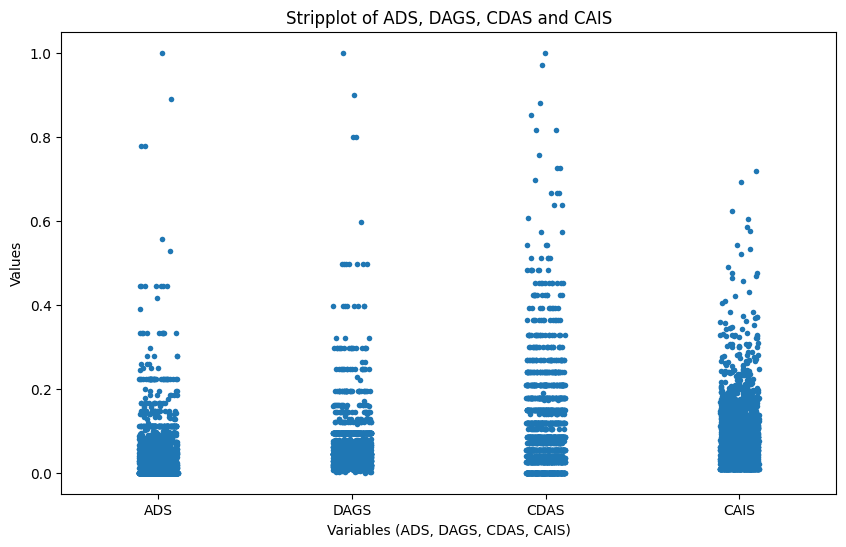

In [ ]:
df = pd.DataFrame(gene_scores).T.reset_index()
df = pd.melt(df, id_vars='index')

plt.figure(figsize=(10, 6))
sns.stripplot(x='variable', y='value', data=df, size=4)
plt.xlabel('Variables (ADS, DAGS, CDAS, CAIS)')
plt.ylabel('Values')
plt.title('Stripplot of ADS, DAGS, CDAS and CAIS')
plt.show()

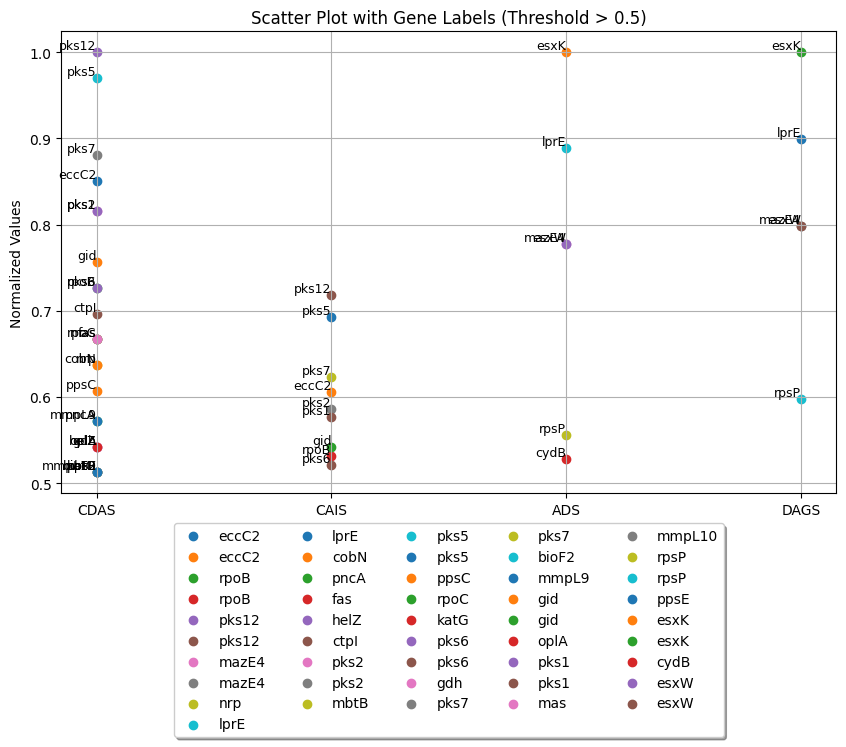

In [ ]:
# Threshold value
threshold = 0.5

# Create a scatter plot
plt.figure(figsize=(10, 6))
for gene, values in gene_scores.items():
    for variable, value in values.items():
        if value > threshold:
            plt.scatter(variable, value, label=gene)
            plt.text(variable, value, gene, fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Set labels and title
plt.xlabel('Variables (ADS, DAGS, CDAS)')
plt.ylabel('Normalized Values')
plt.title('Scatter Plot with Gene Labels (Threshold > {})'.format(threshold))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

# Show the plot
plt.grid()
plt.show()

In [ ]:
# Create a DataFrame from the data
df = pd.DataFrame(gene_scores).T

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='ADS', y='DAGS', z='CDAS', text=df.index)

# Customize the plot appearance
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(scene=dict(xaxis_title='ADS', yaxis_title='DAGS', zaxis_title='CDAS'))
fig.update_layout(title='3D Scatter Plot of ADS, DAGS, and CDAS')
fig.update_layout(legend_title_text='Gene')
fig.update_layout(autosize=False, width=800, height=600)

# Show the interactive plot
fig.show()

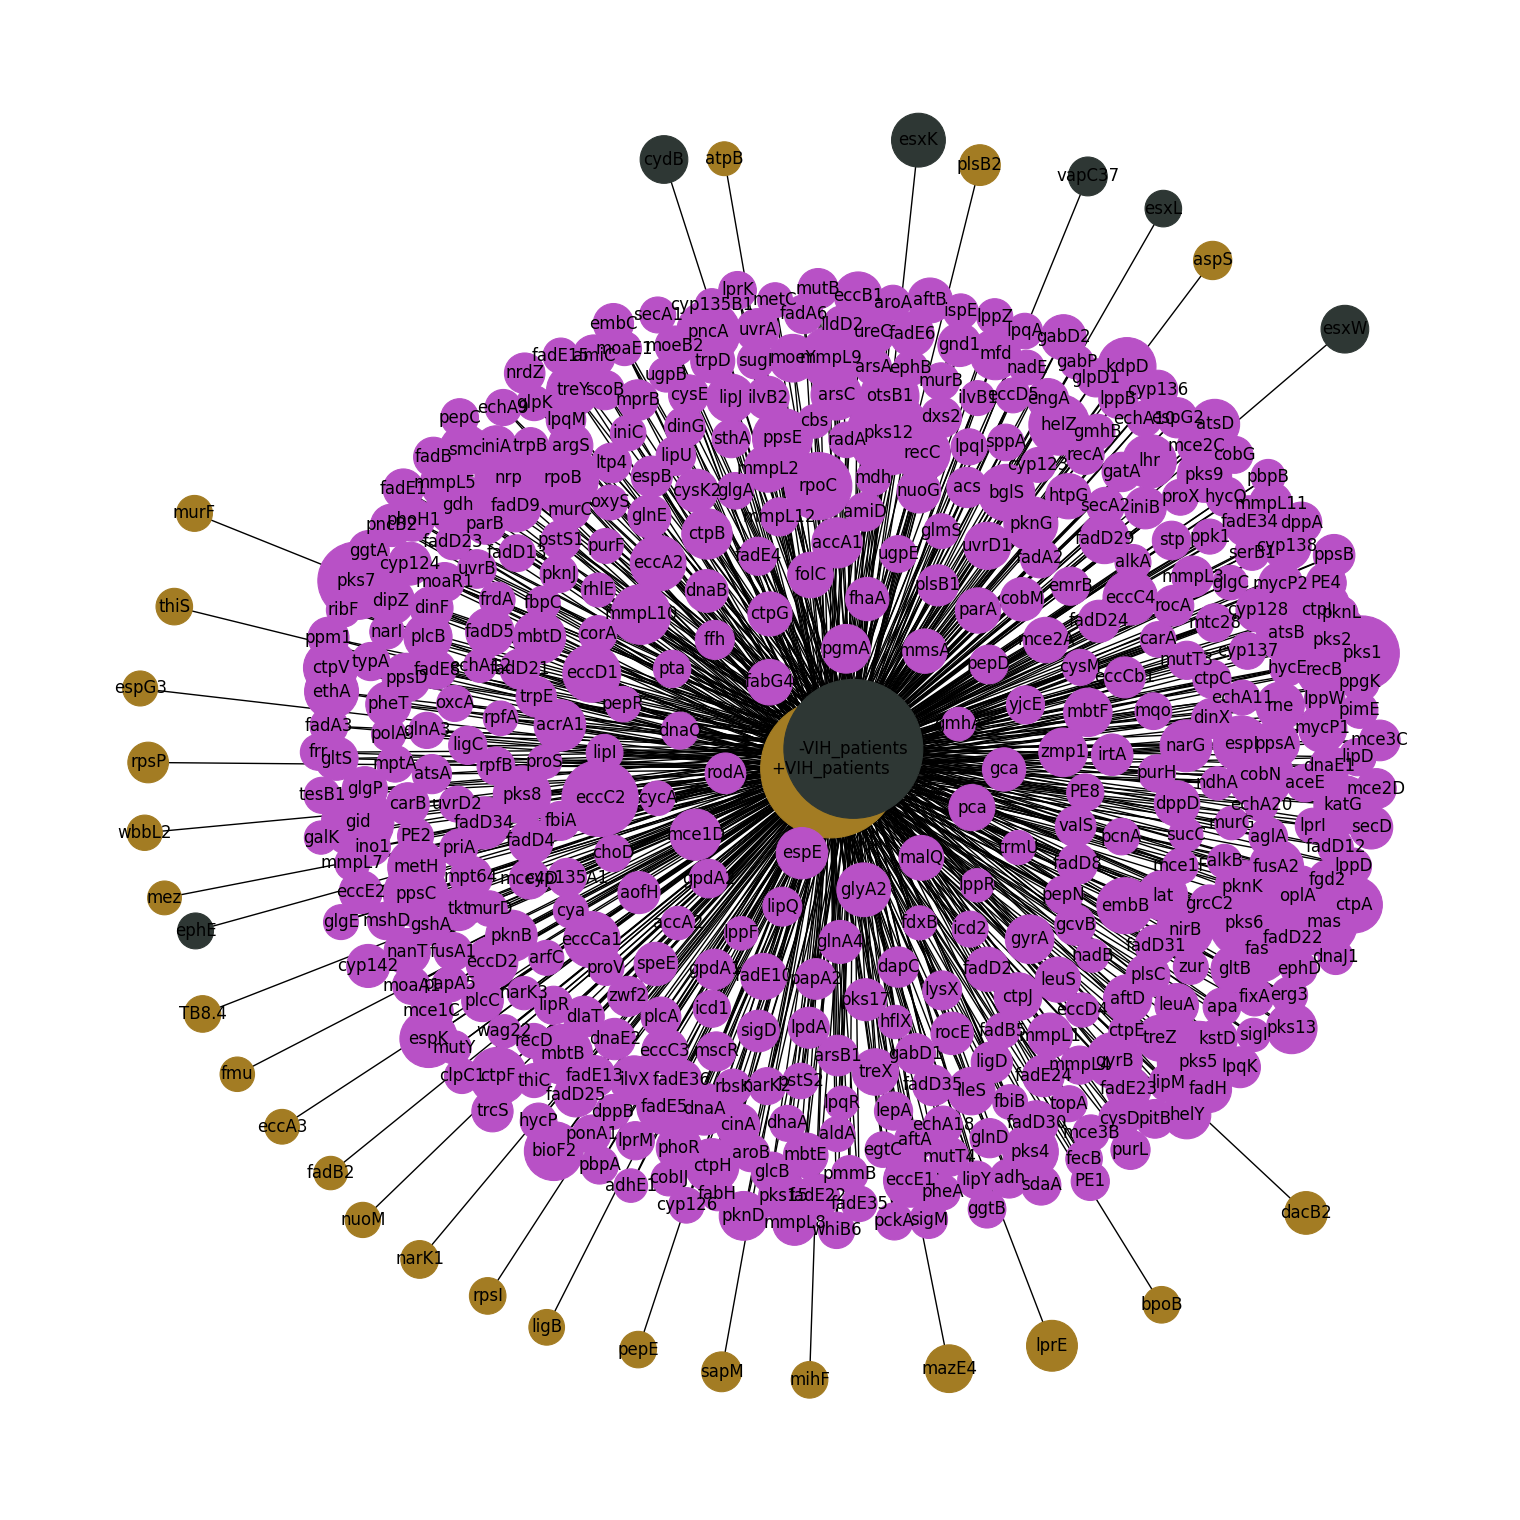

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale = 3)
pos = nx.spring_layout(Variations_network)
plt.figure(figsize=(15,15))
nx.draw(Variations_network,
        node_color = [Variations_network.nodes[node]['color'] for node in Variations_network.nodes],
        node_size = [Variations_network.nodes[node]['size'] for node in Variations_network.nodes],
        pos = pos,
        with_labels= True)

### Pareto front

In optimization types, we can find the multi-objective optimization, which persues finding the optimal solution of a set of goals, matemathically we can stablish it as follows:

\begin{align*}
    f_{1,opt} &= min f_{1}(x) \\
    f_{2,opt} &= min f_{1}(x) \\
    f_{3,opt} &= min f_{1}(x) \\
    . \\
    . \\
    . \\
    f_{n,opt} &= min f_{1}(x) \\
\end{align*}

Pareto method introduces the concept of dominance, classifying the solutions either in dominated or non-dominated, this domination is determined by the existance of an non-improvable objective with out affecting the others functions. Every solution that accomplishes this condition belongs a set known as Pareto Optimal.

Based on gotten scores, we nitced that the most insightful metric regrading phenotype analyzed is CDAS, followed by ADS to finally the DAGS, we procced to find the pareto frontiers based on these parameters taking into account the hierarchical criteria mentioned before.

In [ ]:
# Assigning edges width

for node in Variations_network.nodes:
  for i,group in zip(range(len(Group_Lists)), Group_Lists):
    if node in Score_genes_info.keys():
      print(node)
      if node in Groups_genes_data[i]:
        print(Score_genes_info[node], Groups_genes_data[i][node])
        # Check edge
        if (group, node) in Variations_network.edges:
          # Positions in common
          common_positions = set(Score_genes_info[node].keys()) & set(Groups_genes_data[i][node].keys())
          print(common_positions, len(common_positions), len(common_positions)/len(Score_genes_info[node]))
          # Assign edge width
          Variations_network.edges[(group, node)]['width'] = len(common_positions)/len(Score_genes_info[node])
    else:
      pass

In [ ]:
# Second network after node prunning
VIH_save_dir = '/gdrive/MyDrive/FunTB/Networks_files/'

nx.write_graphml(G = Variations_network,
                 path = VIH_save_dir + 'Graph_MDR.graphml',
                 named_key_ids = True)

nx.write_gexf(Variations_network, VIH_save_dir + "Graph_MDR.gexf")
nx.write_gml(Variations_network, VIH_save_dir  + "Graph_MDR.gml")

## Results and Discussions


## Conclusion

## References

## Acknowledgments

## Future Work